In [2]:
import numpy as np
from typing import Tuple
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [47]:
from maze import Maze

# Constants
GAME_HEIGHT = 600
GAME_WIDTH = 600
NUMBER_OF_TILES = 25
SCREEN_HEIGHT = 700
SCREEN_WIDTH = 700
TILE_SIZE = GAME_HEIGHT // NUMBER_OF_TILES

# Maze layout
level = [
    "XXXXXXXXXXXXXXXXXXXXXXXXX",
    "X XXXXXXXX          XXXXX",
    "X XXXXXXXX  XXXXXX  XXXXX",
    "XP     XXX  XXXXXX  XXXXX",
    "X      XXX  XXX         X",
    "XXXXXX  XX  XXX        XX",
    "XXXXXX  XX  XXXXXX  XXXXX",
    "XXXXXX  XX  XXXXXX  XXXXX",
    "X  XXX      XXXXXXXXXXXXX",
    "X  XXX  XXXXXXXXXXXXXXXXX",
    "X         XXXXXXXXXXXXXXX",
    "X             XXXXXXXXXXX",
    "XXXXXXXXXXX      XXXXX  X",
    "XXXXXXXXXXXXXXX  XXXXX  X",
    "XXX  XXXXXXXXXX         X",
    "XXX                     X",
    "XXX         XXXXXXXXXXXXX",
    "XXXXXXXXXX  XXXXXXXXXXXXX",
    "XXXXXXXXXX              X",
    "XX   XXXXX              X",
    "XX   XXXXXXXXXXXXX  XXXXX",
    "XX    XXXXXXXXXXXX  XXXXX",
    "XX        XXXX          X",
    "XXXX                    X",
    "XXXXXXXXXXXXXXXXXXXXXXXXX",
]

env = Maze(
    level,
    goal_pos=(23, 20),
    MAZE_HEIGHT=GAME_HEIGHT,
    MAZE_WIDTH=GAME_WIDTH,
    SIZE=NUMBER_OF_TILES,
)

In [48]:
NO_OF_ACTIONS = 4

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_policy(probs_or_qvals, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'L', 1: 'U', 2: 'R', 3: 'D'}
    fig = plt.figure(figsize=(7,7))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(np.object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2)
    plt.axis("off")
    plt.suptitle("Policy", size=24)
    plt.tight_layout()

### Define Action Values 

In [50]:
# action_values = np.zeros((env.number_of_tiles, env.number_of_tiles, NO_OF_ACTIONS))
action_values = np.full((env.number_of_tiles, env.number_of_tiles, NO_OF_ACTIONS), -100)
# set action value for goal state to 0
action_values[env.goal_pos]=0


### Define Target Policy $\pi(a|s)$   

In [51]:
def target_policy(state):
    av = action_values[state]
    return np.random.choice(np.flatnonzero(av == av.max()))

In [52]:
target_policy((0,0))

3

### Define Exploratory Policy $b(a|s)$

In [53]:
import numpy as np
def exploratory_policy(state, epsilon):

    if np.random.rand() < epsilon:
        return np.random.choice(NO_OF_ACTIONS)
    
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

In [54]:
exploratory_policy((0,0), epsilon = 0.5)

3

## Off Policy Monte Carlo Algorithm

In [55]:
def run_episode(action_values, target_policy, exploratory_policy, epsilon, gamma = 0.99):
   
        G = 0
        W = 1
        done = False
        transitions = []
        env.state = env.reset_state()

        while not done:
            prev_state = env.state
            action = exploratory_policy(env.state, epsilon)
            next_state, reward, done = env.step(action)
            env.state = next_state
            transitions.append((prev_state, action, reward))

        for state_t, action_t, reward_t in reversed(transitions):
            G = reward_t + gamma * G
            csa[state_t][action_t] += W
            qsa = action_values[state_t][action_t]
            action_values[state_t][action_t] = qsa + (G - qsa) * (W/ csa[state_t][action_t])

            if action_t != target_policy(state_t):
                break

            else:
                W = W / ((1-epsilon) + (epsilon/NO_OF_ACTIONS))

        return action_values



In [56]:
csa = np.zeros((env.number_of_tiles, env.number_of_tiles, NO_OF_ACTIONS))

def mc_off_policy_control(action_values,target_policy, exploratory_policy, epsilon, episodes = 1000, gamma = 0.99):

    for i in tqdm(range(1, episodes+1)):
        
        run_episode(action_values, target_policy, exploratory_policy, epsilon, gamma)


In [57]:
def mc_on_policy_control(action_values, exploratory_policy, epsilon, episodes = 1000, gamma = 0.99, alpha = 0.2):
    
    fail = 0

    for i in tqdm(range(1, episodes+1)):
        
        G = 0
        done = False
        transitions = []
        env.state = env.reset_state()

        while not done:
            prev_state = env.state
            action = exploratory_policy(env.state, epsilon)
            next_state, reward, done = env.step(action)
            env.state = next_state
            transitions.append((prev_state, action, reward))
            if len(transitions) > 100000:
                fail += 1
                print(fail)
                break
                
        if len(transitions) < 100000:
            for state_t, action_t, reward_t in reversed(transitions):
                G = reward_t + gamma * G
                qsa = action_values[state_t][action_t]
                action_values[state_t][action_t] = qsa + (G - qsa) * alpha

In [58]:
# mc_on_policy_control(action_values, exploratory_policy, episodes = 3000, epsilon = 0.3)

In [59]:
result = Parallel(n_jobs=-1)(delayed(run_episode)(action_values, target_policy, exploratory_policy, epsilon = 0.3) for _ in tqdm(range(3000)))

  0%|          | 0/3000 [00:00<?, ?it/s]

In [60]:
# mc_off_policy_control(action_values, target_policy, exploratory_policy, epsilon = 0.3, episodes = 10000, gamma = 0.99)

In [3]:
action = np.load("off_policy_10000_episodes.npy")

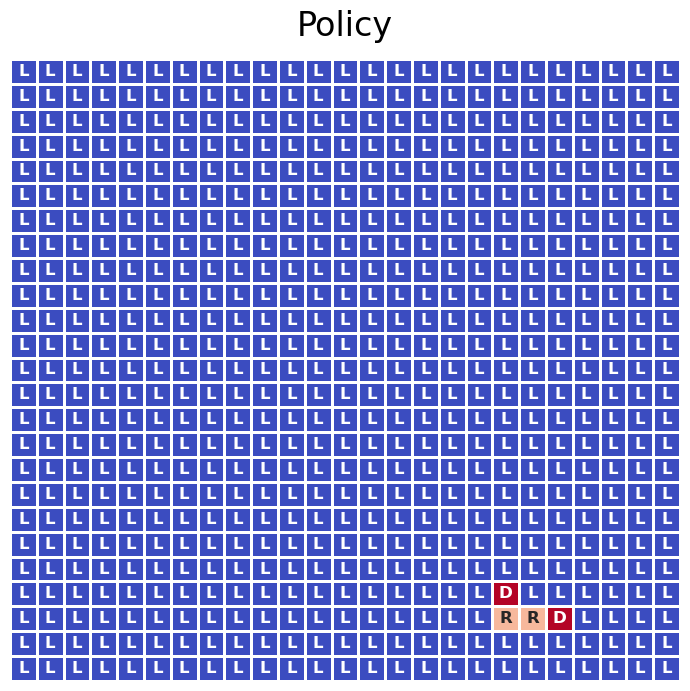

In [6]:
plot_policy(action)